In [4]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from ta import add_all_ta_features
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Model

In [26]:
def build_momentum(df):
    df["mom_6m"] = np.log(df.close)-np.log(df.close.shift(6))
    df["mom_1m"] = np.log(df.close)-np.log(df.close.shift(1))
    df["log_return"] = np.log(df.close.shift(-1)) - np.log(df.close)
    return df.loc[df.prccd > 5, ["mcap_pctl", "mom_6m", "mom_1m", "log_return"]].dropna()

In [27]:
def be_extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.log_return.quantile(0.8)
    low = df.log_return.quantile(0.2)
    return df[(df.log_return < low) | (df.log_return > top)]

In [29]:
df = pd.read_parquet("../data/merged_data_alpha.6.parquet")
df_basic = df[["mcap_pctl", "prccd", "close"]]
df_mom = df_basic.groupby("gvkey").apply(build_momentum)

<AxesSubplot:xlabel='mom_6m', ylabel='log_return'>

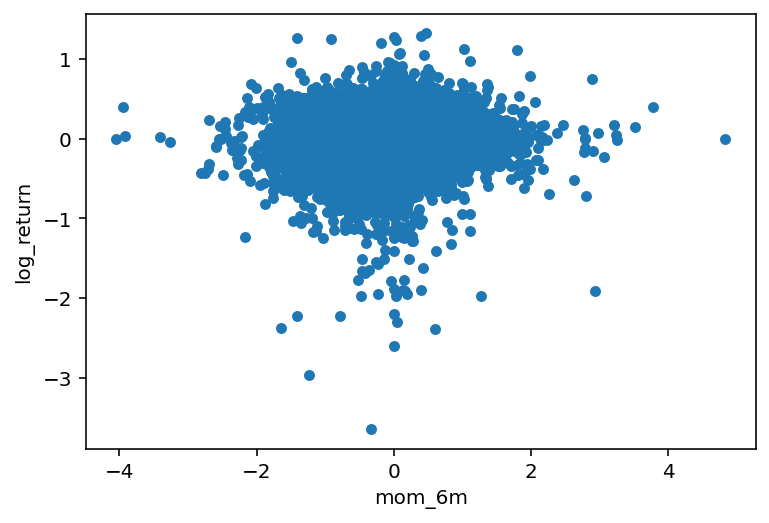

In [30]:
df_mom.plot.scatter(x="mom_6m", y="log_return")

<AxesSubplot:xlabel='mcap_pctl', ylabel='log_return'>

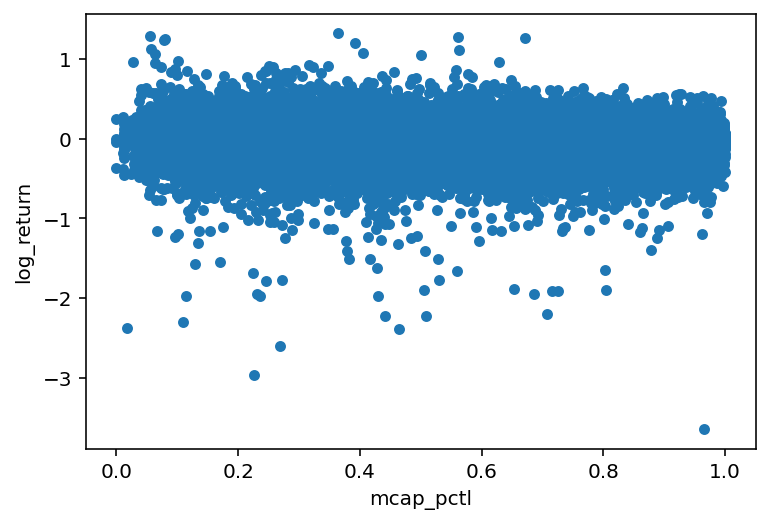

In [32]:
df_mom.plot.scatter(x="mcap_pctl", y="log_return")

In [33]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(be_extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)

In [34]:
X_train = df_train.drop("log_return", axis=1).to_numpy()
y_train = df_train["log_return"].to_numpy()
X_test = df_test.drop("log_return", axis=1).to_numpy()
y_test = df_test["log_return"].to_numpy()

In [35]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_train, y_train))
print(xgb_reg.score(X_test, y_test))

0.06438009253331178
-0.023873438483213105


In [37]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, np.sign(y_train))
print(xgb_clf.score(X_train, np.sign(y_train)))
print(xgb_clf.score(X_test, np.sign(y_test)))

/Users/Jiawei/.pyenv/versions/3.8.7/envs/quant/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:30:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5637940770485632
0.4902346399023464


In [38]:
def be_extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [39]:
def be_balance(df):
    """Returns minus a cross-sectional median"""
    median = df.log_return.quantile(0.5)
    df["y"] = df.log_return - median
    return df

In [40]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(be_balance).groupby("date").apply(be_extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False).groupby("date").apply(be_balance)
X_train = df_train.drop("log_return", axis=1).to_numpy()
y_train = df_train["log_return"].to_numpy()
X_test = df_test.drop("log_return", axis=1).to_numpy()
y_test = df_test["log_return"].to_numpy()

<AxesSubplot:xlabel='mom_6m', ylabel='y'>

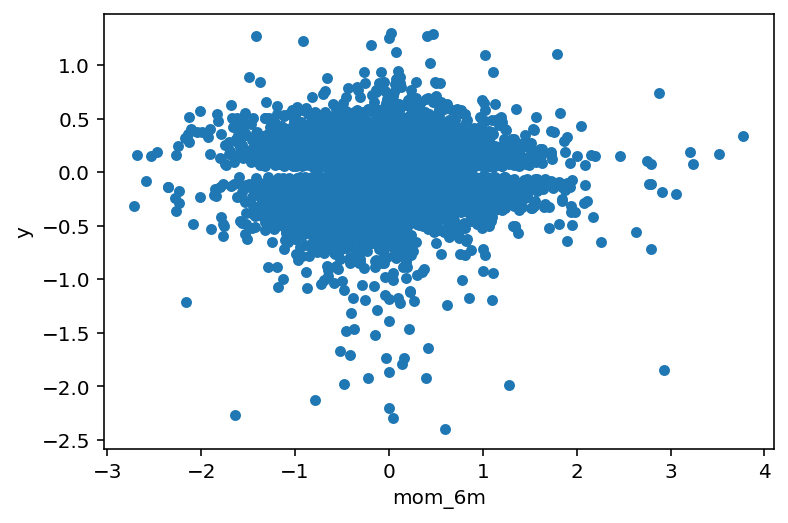

In [41]:
df_train.plot.scatter(x="mom_6m", y="y")

<AxesSubplot:xlabel='mcap_pctl', ylabel='y'>

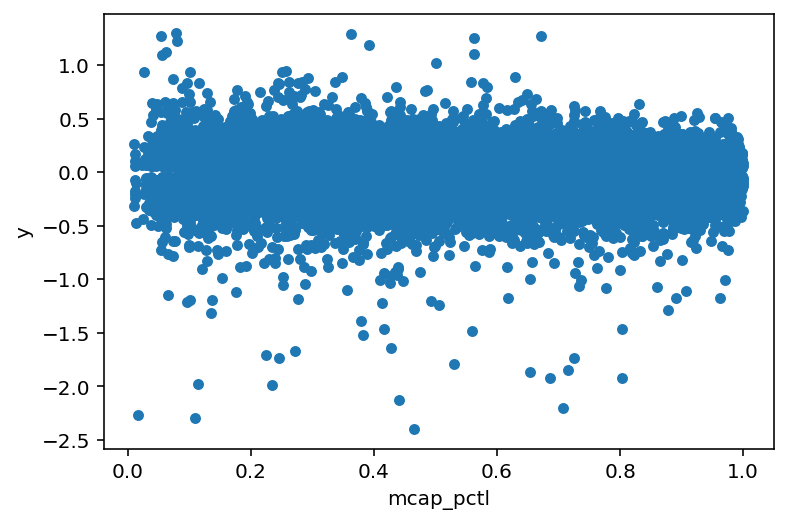

In [42]:
df_train.plot.scatter(x="mcap_pctl", y="y")

In [43]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_train, y_train))
print(xgb_reg.score(X_test, y_test))

0.9593068031816131
0.9306410331279277


In [44]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, np.sign(y_train))
print(xgb_clf.score(X_train, np.sign(y_train)))
print(xgb_clf.score(X_test, np.sign(y_test)))

/Users/Jiawei/.pyenv/versions/3.8.7/envs/quant/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:31:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9918904504956707
0.8575206835752068


The algorithm works after rebalancing.